In [22]:
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import os
import pickle



In [23]:

df_4_files_combined_no_outliers_for_AR = pd.read_pickle('df_file_combined_actual_no_outliers_for_AR.pkl')
df_4_files_combined_no_outliers_for_AR.index = pd.to_datetime(df_4_files_combined_no_outliers_for_AR.index)
df_4_files_combined_no_outliers_for_AR = df_4_files_combined_no_outliers_for_AR.asfreq('D')  # or 'W', 'M' depending on your data's granularity


In [24]:
# ----------- Data Preparation -----------

def prepare_prophet_data(df, target_col='Room Revenue', exogenous_cols=None):
    prophet_df = pd.DataFrame({'ds': df.index, 'y': df[target_col]})
    
    # Add exogenous regressors
    if exogenous_cols:
        for col in exogenous_cols:
            if col in df.columns:
                prophet_df[col] = df[col]
    
    # Day of week (one-hot)
    for i in range(7):
        prophet_df[f'day_{i}'] = (prophet_df['ds'].dt.dayofweek == i).astype(int)
    
    # Weekend flag
    prophet_df['is_weekend'] = prophet_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)
    
    # Month and quarter
    prophet_df['month'] = prophet_df['ds'].dt.month
    prophet_df['quarter'] = prophet_df['ds'].dt.quarter
    # prophet_df['day_of_year'] = prophet_df['ds'].dt.dayofyear

    
    # IN holidays
    us_holidays = holidays.IN()
    prophet_df['is_holiday'] = (prophet_df['ds'].dt.date.apply(lambda x: x in us_holidays)).astype(int)
    
    # Rolling stats on target (7 and 14 days)
    if not pd.isna(df[target_col]).all():
        for window in [7,14]:
            prophet_df[f'rolling_mean_{window}d'] = df[target_col].rolling(window=window).mean().values
            prophet_df[f'rolling_std_{window}d'] = df[target_col].rolling(window=window).std().values
    
    
    prophet_df.fillna(method='bfill', inplace=True)
    prophet_df.fillna(method='ffill', inplace=True)

    return prophet_df




In [25]:
# ----------- Save/Load Model -----------

def save_model(model, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")

def load_model(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No model file found at {filepath}")
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model


In [26]:
# ----------- Prediction Functions -----------
import os
save_folder = "plots_prophet"

# Create the folder if it doesn't exist
os.makedirs(save_folder, exist_ok=True)
def predict_for_dates(dates, model, reference_df):
    if isinstance(dates, (str, pd.Timestamp)):
        dates = [dates]
    dates = pd.to_datetime(dates)
    
    future_dates = pd.DataFrame({'ds': dates})
    us_holidays = holidays.IN()
    
    for col in reference_df.columns:
        if col not in ['ds', 'y']:
            if col.startswith('day_'):
                day_num = int(col.split('_')[1])
                future_dates[col] = (future_dates['ds'].dt.dayofweek == day_num).astype(int)
            elif col == 'is_weekend':
                future_dates[col] = future_dates['ds'].dt.dayofweek.isin([5,6]).astype(int)
            elif col == 'month':
                future_dates[col] = future_dates['ds'].dt.month
            elif col == 'quarter':
                future_dates[col] = future_dates['ds'].dt.quarter
            elif col == 'is_holiday':
                future_dates[col] = (future_dates['ds'].dt.date.apply(lambda x: x in us_holidays)).astype(int)
            else:
                future_dates[col] = reference_df[col].iloc[-1]
    
    forecast = model.predict(future_dates)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


def predict_with_loaded_model(filepath, dates, reference_df):
    model = load_model(filepath)
    return predict_for_dates(dates, model=model, reference_df=reference_df)


# ----------- Hyperparameter Optimization -----------

def objective(params):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    for col in prophet_data.columns:
        if col not in ['ds', 'y']:
            model.add_regressor(col)
    
    model.fit(prophet_data)
    
    df_cv = cross_validation(
        model, 
        initial='366 days',
        period='30 days',
        horizon='30 days',
        parallel="processes"
    )
    
    df_p = performance_metrics(df_cv)
    rmse = df_p['rmse'].mean()
    
    return {'loss': rmse, 'status': STATUS_OK}


# ----------- Helper function to add regressors to future dfs -----------

def add_regressors(future_df, reference_df):
    in_holidays = holidays.IN()
    for col in reference_df.columns:
        if col not in ['ds', 'y']:
            if col.startswith('day_'):
                day_num = int(col.split('_')[1])
                future_df[col] = (future_df['ds'].dt.dayofweek == day_num).astype(int)
            elif col == 'is_weekend':
                future_df[col] = future_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)
            elif col == 'month':
                future_df[col] = future_df['ds'].dt.month
            elif col == 'quarter':
                future_df[col] = future_df['ds'].dt.quarter
            elif col == 'is_holiday':
                future_df[col] = (future_df['ds'].dt.date.apply(lambda x: x in in_holidays)).astype(int)
            else:
                future_df[col] = reference_df[col].iloc[-1]
    return future_df


# ----------- Plot function -----------

def plot_forecast(forecast_df, title):
    plt.figure(figsize=(12,6))
    plt.plot(prophet_data['ds'], prophet_data['y'], 'k.', label='Historical')
    plt.plot(forecast_df['ds'], forecast_df['yhat'], 'b-', label='Forecast')
    # plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'], color='blue', alpha=0.2, label='95% CI')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gcf().autofmt_xdate()

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Room Revenue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_folder, f"{title.replace(' ', '_').lower()}.png"))
    plt.show()


  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

14:52:38 - cmdstanpy - INFO - Chain [1] start processing

14:52:39 - cmdstanpy - INFO - Chain [1] done processing



  3%|▎         | 1/30 [00:06<03:14,  6.72s/trial, best loss: 65504.1577250216]

14:52:45 - cmdstanpy - INFO - Chain [1] start processing

14:52:46 - cmdstanpy - INFO - Chain [1] done processing



  7%|▋         | 2/30 [00:13<03:02,  6.53s/trial, best loss: 65504.1577250216]

14:52:51 - cmdstanpy - INFO - Chain [1] start processing

14:52:52 - cmdstanpy - INFO - Chain [1] done processing



 10%|█         | 3/30 [00:18<02:44,  6.10s/trial, best loss: 65504.1577250216]

14:52:57 - cmdstanpy - INFO - Chain [1] start processing

14:52:57 - cmdstanpy - INFO - Chain [1] done processing



 13%|█▎        | 4/30 [00:23<02:27,  5.66s/trial, best loss: 55123.821435121135]

14:53:02 - cmdstanpy - INFO - Chain [1] start processing

14:53:03 - cmdstanpy - INFO - Chain [1] done processing



 17%|█▋        | 5/30 [00:29<02:25,  5.83s/trial, best loss: 55123.821435121135]

14:53:08 - cmdstanpy - INFO - Chain [1] start processing

14:53:09 - cmdstanpy - INFO - Chain [1] done processing



 20%|██        | 6/30 [00:34<02:12,  5.53s/trial, best loss: 55123.821435121135]

14:53:13 - cmdstanpy - INFO - Chain [1] start processing

14:53:13 - cmdstanpy - INFO - Chain [1] done processing



 23%|██▎       | 7/30 [00:39<02:02,  5.33s/trial, best loss: 55123.821435121135]

14:53:18 - cmdstanpy - INFO - Chain [1] start processing

14:53:19 - cmdstanpy - INFO - Chain [1] done processing



 27%|██▋       | 8/30 [00:45<02:03,  5.61s/trial, best loss: 55123.821435121135]

14:53:24 - cmdstanpy - INFO - Chain [1] start processing

14:53:25 - cmdstanpy - INFO - Chain [1] done processing



 30%|███       | 9/30 [00:50<01:53,  5.39s/trial, best loss: 55123.821435121135]

14:53:29 - cmdstanpy - INFO - Chain [1] start processing

14:53:30 - cmdstanpy - INFO - Chain [1] done processing



 33%|███▎      | 10/30 [00:56<01:51,  5.56s/trial, best loss: 55123.821435121135]

14:53:35 - cmdstanpy - INFO - Chain [1] start processing

14:53:36 - cmdstanpy - INFO - Chain [1] done processing



 37%|███▋      | 11/30 [01:02<01:45,  5.55s/trial, best loss: 55123.821435121135]

14:53:41 - cmdstanpy - INFO - Chain [1] start processing

14:53:41 - cmdstanpy - INFO - Chain [1] done processing



 40%|████      | 12/30 [01:07<01:36,  5.34s/trial, best loss: 54004.207122049076]

14:53:46 - cmdstanpy - INFO - Chain [1] start processing

14:53:46 - cmdstanpy - INFO - Chain [1] done processing



 43%|████▎     | 13/30 [01:13<01:35,  5.61s/trial, best loss: 54004.207122049076]

14:53:52 - cmdstanpy - INFO - Chain [1] start processing

14:53:52 - cmdstanpy - INFO - Chain [1] done processing



 47%|████▋     | 14/30 [01:19<01:31,  5.72s/trial, best loss: 54004.207122049076]

14:53:58 - cmdstanpy - INFO - Chain [1] start processing

14:53:58 - cmdstanpy - INFO - Chain [1] done processing



 50%|█████     | 15/30 [01:25<01:29,  5.94s/trial, best loss: 54004.207122049076]

14:54:04 - cmdstanpy - INFO - Chain [1] start processing

14:54:05 - cmdstanpy - INFO - Chain [1] done processing



 53%|█████▎    | 16/30 [01:33<01:30,  6.47s/trial, best loss: 54004.207122049076]

14:54:12 - cmdstanpy - INFO - Chain [1] start processing

14:54:12 - cmdstanpy - INFO - Chain [1] done processing



 57%|█████▋    | 17/30 [01:38<01:19,  6.15s/trial, best loss: 54004.207122049076]

14:54:17 - cmdstanpy - INFO - Chain [1] start processing

14:54:18 - cmdstanpy - INFO - Chain [1] done processing



 60%|██████    | 18/30 [01:45<01:15,  6.29s/trial, best loss: 54004.207122049076]

14:54:24 - cmdstanpy - INFO - Chain [1] start processing

14:54:25 - cmdstanpy - INFO - Chain [1] done processing



 63%|██████▎   | 19/30 [01:53<01:13,  6.66s/trial, best loss: 54004.207122049076]

14:54:31 - cmdstanpy - INFO - Chain [1] start processing

14:54:33 - cmdstanpy - INFO - Chain [1] done processing



 67%|██████▋   | 20/30 [02:00<01:09,  6.95s/trial, best loss: 54004.207122049076]

14:54:39 - cmdstanpy - INFO - Chain [1] start processing

14:54:39 - cmdstanpy - INFO - Chain [1] done processing



 70%|███████   | 21/30 [02:05<00:57,  6.35s/trial, best loss: 53751.077932316526]

14:54:44 - cmdstanpy - INFO - Chain [1] start processing

14:54:44 - cmdstanpy - INFO - Chain [1] done processing



 73%|███████▎  | 22/30 [02:10<00:47,  5.94s/trial, best loss: 53751.077932316526]

14:54:49 - cmdstanpy - INFO - Chain [1] start processing

14:54:49 - cmdstanpy - INFO - Chain [1] done processing



 77%|███████▋  | 23/30 [02:16<00:40,  5.86s/trial, best loss: 53681.13541929673] 

14:54:55 - cmdstanpy - INFO - Chain [1] start processing

14:54:55 - cmdstanpy - INFO - Chain [1] done processing



 80%|████████  | 24/30 [02:22<00:36,  6.12s/trial, best loss: 53681.13541929673]

14:55:02 - cmdstanpy - INFO - Chain [1] start processing

14:55:02 - cmdstanpy - INFO - Chain [1] done processing



 83%|████████▎ | 25/30 [02:29<00:31,  6.29s/trial, best loss: 53413.81234168291]

14:55:08 - cmdstanpy - INFO - Chain [1] start processing

14:55:09 - cmdstanpy - INFO - Chain [1] done processing



 87%|████████▋ | 26/30 [02:35<00:24,  6.22s/trial, best loss: 53413.81234168291]

14:55:14 - cmdstanpy - INFO - Chain [1] start processing

14:55:15 - cmdstanpy - INFO - Chain [1] done processing



 90%|█████████ | 27/30 [02:42<00:19,  6.50s/trial, best loss: 53413.81234168291]

14:55:21 - cmdstanpy - INFO - Chain [1] start processing

14:55:22 - cmdstanpy - INFO - Chain [1] done processing



 93%|█████████▎| 28/30 [02:49<00:12,  6.40s/trial, best loss: 53413.81234168291]

14:55:28 - cmdstanpy - INFO - Chain [1] start processing

14:55:28 - cmdstanpy - INFO - Chain [1] done processing



 97%|█████████▋| 29/30 [02:55<00:06,  6.42s/trial, best loss: 53413.81234168291]

14:55:34 - cmdstanpy - INFO - Chain [1] start processing

14:55:35 - cmdstanpy - INFO - Chain [1] done processing



100%|██████████| 30/30 [03:01<00:00,  6.06s/trial, best loss: 53413.81234168291]
Best parameters found: {'changepoint_prior_scale': 1.0519060689869324, 'seasonality_prior_scale': 2.033305353356139, 'holidays_prior_scale': 1.2655056401497708, 'seasonality_mode': 'additive'}


14:55:40 - cmdstanpy - INFO - Chain [1] start processing

14:55:41 - cmdstanpy - INFO - Chain [1] done processing



Model saved to final_model_prophet.pkl
Best loss: 53413.81234168291
Best loss saved to best_loss.txt
Predictions for specific dates:
          ds          yhat    yhat_lower    yhat_upper
0 2025-06-20  1.814356e+06  1.749482e+06  1.870808e+06
1 2025-07-01  1.793823e+06  1.654213e+06  1.930953e+06
2 2025-09-15  1.722503e+06  1.463312e+06  1.975180e+06


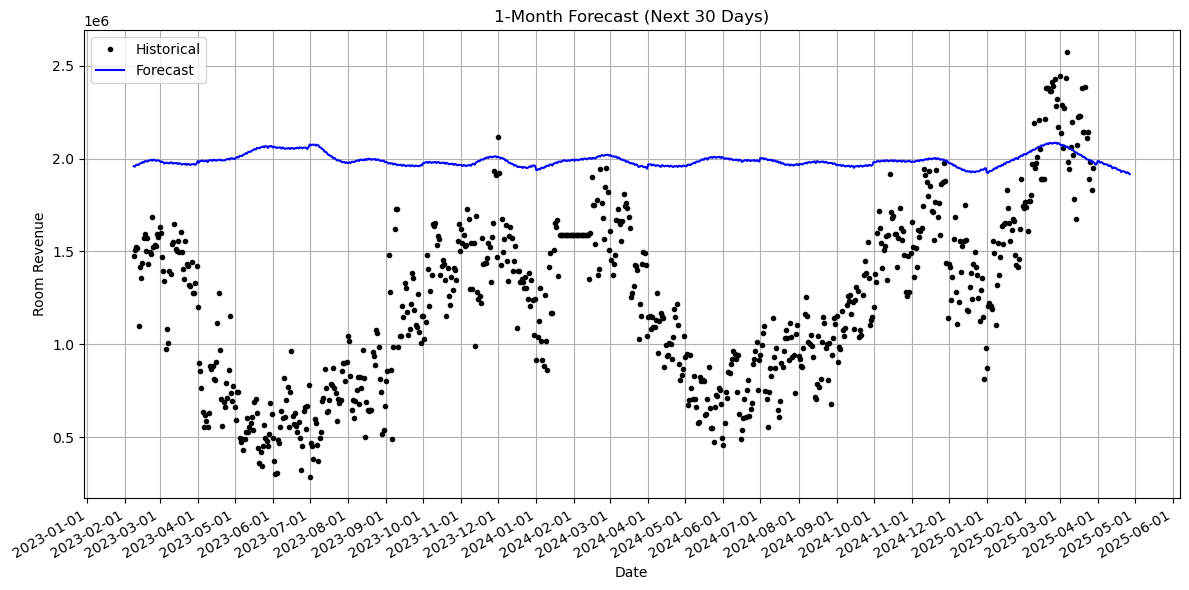

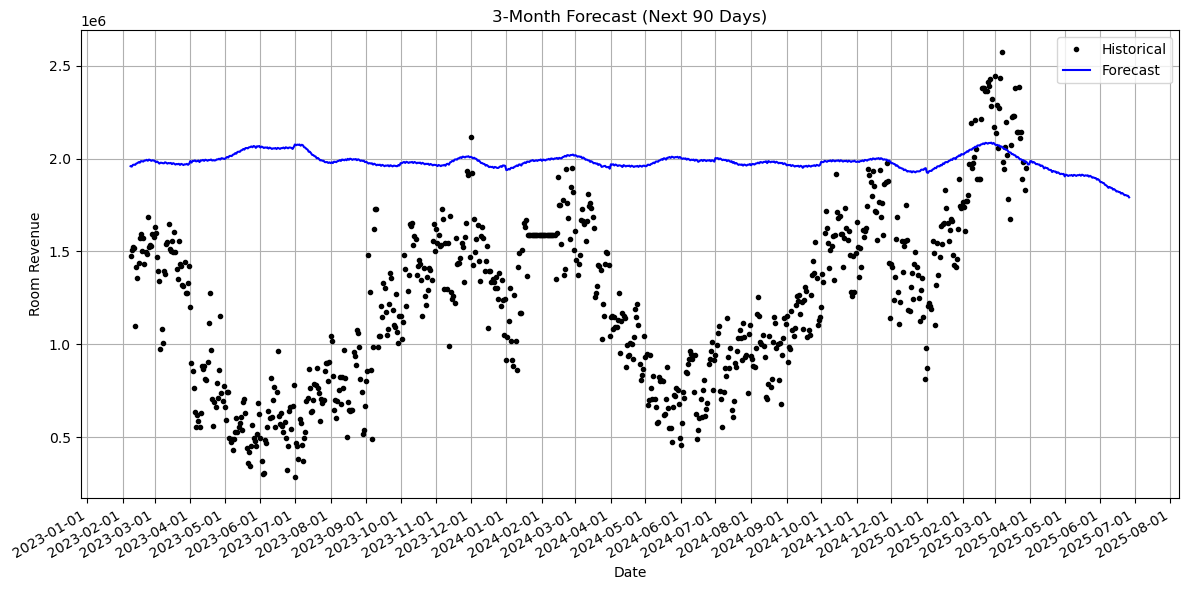

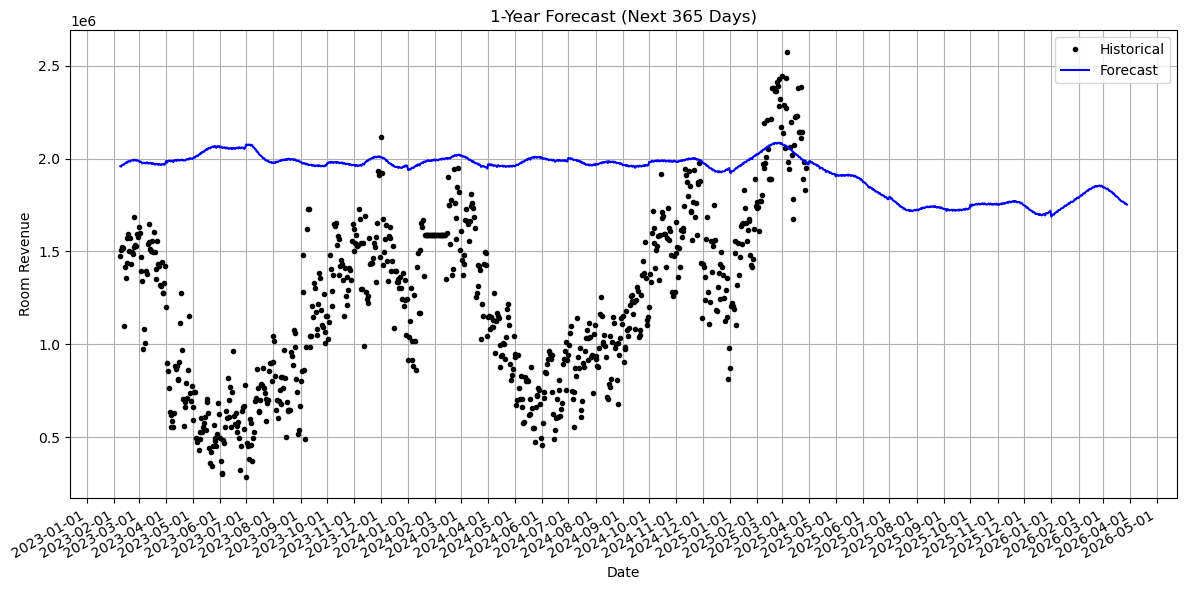

In [27]:
# ----------- Main Execution -----------

# Your dataframe with datetime index and data - replace with your actual df
# Example:
# df_4_files_combined_no_outliers_for_AR = pd.read_csv('your_data.csv', parse_dates=['date_column'], index_col='date_column')

exog_cols = ['Rooms Sold', 'Occupancy %', 'ARR', 'Pax']  # example exogenous columns

prophet_data = prepare_prophet_data(df_4_files_combined_no_outliers_for_AR, target_col='Room Revenue', exogenous_cols=exog_cols)

space = {
    'changepoint_prior_scale': hp.loguniform('changepoint_prior_scale', -3, 0),
    'seasonality_prior_scale': hp.loguniform('seasonality_prior_scale', -2, 1),
    'holidays_prior_scale': hp.loguniform('holidays_prior_scale', -2, 0),
    'seasonality_mode': hp.choice('seasonality_mode', ['additive', 'multiplicative'])
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

best_params = {
    'changepoint_prior_scale': np.exp(best['changepoint_prior_scale']),
    'seasonality_prior_scale': np.exp(best['seasonality_prior_scale']),
    'holidays_prior_scale': np.exp(best['holidays_prior_scale']),
    'seasonality_mode': ['additive', 'multiplicative'][best['seasonality_mode']]
}
print("Best parameters found:", best_params)

final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False
)

for col in prophet_data.columns:
    if col not in ['ds', 'y']:
        final_model.add_regressor(col)

final_model.fit(prophet_data)

# Save final model
save_model(final_model, 'final_model_prophet.pkl')

# Get the best loss from the trials
best_loss = min([trial['result']['loss'] for trial in trials.trials])
print("Best loss:", best_loss)

# Save to a text file
with open("best_loss.txt", "w") as f:
    f.write(f"Best Loss (RMSE): {best_loss:.4f}\n")

print("Best loss saved to best_loss.txt")

# ----------- Forecast for next 1 month and 3 months -----------

future_1m = final_model.make_future_dataframe(periods=30)
future_3m = final_model.make_future_dataframe(periods=90)

future_1m = add_regressors(future_1m, prophet_data)
future_3m = add_regressors(future_3m, prophet_data)

forecast_1m = final_model.predict(future_1m)
forecast_3m = final_model.predict(future_3m)

# ----------- Forecast for next 1 year -----------

future_1y = final_model.make_future_dataframe(periods=365)
future_1y = add_regressors(future_1y, prophet_data)
forecast_1y = final_model.predict(future_1y)


# ----------- Predict for specific dates -----------

specific_dates = ['2025-06-20', '2025-07-01', '2025-09-15']
pred_specific = predict_for_dates(specific_dates, model=final_model, reference_df=prophet_data)
print("Predictions for specific dates:")
print(pred_specific)


# ----------- Plot forecasts -----------

plot_forecast(forecast_1m, '1-Month Forecast (Next 30 Days)')
plot_forecast(forecast_3m, '3-Month Forecast (Next 90 Days)')
plot_forecast(forecast_1y, '1-Year Forecast (Next 365 Days)')


.

























.

In [28]:
prophet_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 2023-02-08 to 2025-03-28
Freq: D
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ds                780 non-null    datetime64[ns]
 1   y                 780 non-null    float64       
 2   Rooms Sold        780 non-null    float64       
 3   Occupancy %       780 non-null    float64       
 4   ARR               780 non-null    float64       
 5   Pax               780 non-null    float64       
 6   day_0             780 non-null    int32         
 7   day_1             780 non-null    int32         
 8   day_2             780 non-null    int32         
 9   day_3             780 non-null    int32         
 10  day_4             780 non-null    int32         
 11  day_5             780 non-null    int32         
 12  day_6             780 non-null    int32         
 13  is_weekend        780 non-null    int32         
 14 